# Data 확인 및 결측값 채우기

In [1]:
from modules.local_values import tickers, raw_datas, datas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('float_format', '{:.2f}'.format)

## 결측값 채우기
volume, value => 0  
실제 거래가 없는 경우는 0  
서버 오류 등 결측값의 경우 결측값을 알림  
  
그 외 가격들은 전부 interpolate로 보간  

In [2]:
for raw_file,tick in zip(raw_datas,tickers):
    df=pd.read_csv(raw_file,parse_dates=[0],index_col=[0])
    df=df.resample(rule='T').first()
    df[['volume','value']]=df[['volume','value']].fillna(0)
    df=df.interpolate()
    msg='Data{:>9}\tTotal:{:>8}\tNaN:{:2}' \
        .format(tick,len(df),df['open'].isnull().sum())
    print(msg)

Data  KRW-BTC	Total: 3249992	NaN: 0
Data  KRW-ETH	Total: 3250422	NaN: 0
Data  KRW-XRP	Total: 3251443	NaN: 0
Data  KRW-SOL	Total: 1120114	NaN: 0
Data KRW-AVAX	Total:  953191	NaN: 0
Data KRW-DOGE	Total: 1456154	NaN: 0
Data  KRW-ETC	Total: 3253345	NaN: 0


## 데이터 전처리
#### 예측에 필요한 정보가 과연 무엇인가  

|주기|추세|불규칙|휴먼이슈|
|:--:|:--:|:--:|:------:|
|계절, 순환, 24시|단기/장기 성장률|뉴스,검색량,트위터|가격 상한선, 예약 매매|
  
주기 > 영향이 적을 것이라 생각  
추세 > 물타기, 가장 영향이 클 것으로 생각  
불규칙 > 추후에 추가  
휴먼 이슈 > 딱 떨어지는 가격, 목표 이율  

### 거래량 주기 파악
각 해의 누적 거래량을 파악한다.  
거래가 활발히 이루어지는 날이 따로 있는지 확인한다.  
  
금액에 따라 거래량이 달라지므로, 종가를 곱해준다. 

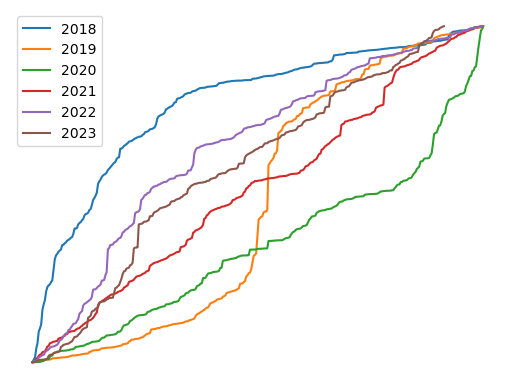

In [3]:
df=pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])
df=df['close']*df['volume']
df=df.resample(rule='D').first()
for i in range(2018,2024):
    df_temp=df.loc[str(i)]
    df_temp=df_temp.reset_index(drop=True).cumsum()
    df_temp=df_temp-df_temp.min()
    df_temp=df_temp/df_temp.max()
    plt.plot(df_temp,label=str(i))
plt.axis('off')
plt.legend()
plt.show()

해마다 주기적으로 거래량의 변화가 나타나지는 않는다.  
다만 한번 상승할 때에 많이 상승하는 것을 알 수 있다.  => 추세

## 주가 지표
주가 분석에서 사용되는 지표들을 사용하여 분석해본다. 
|RSI|BB/BP|MACD|dis|Mmt|EMA|
|---|-----|----|---|---|---|
|상대 강도지수|볼린저밴드|추세지표|이격도|모멘텀|지수 이동평균|

In [4]:
import modules.indicators as idc
df=pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])[:400].sort_index()
df['close_MM'] = idc.MinMaxN(df['close'])

### 지수 이동 평균
러프한 값으로 지표를 표현한다. 

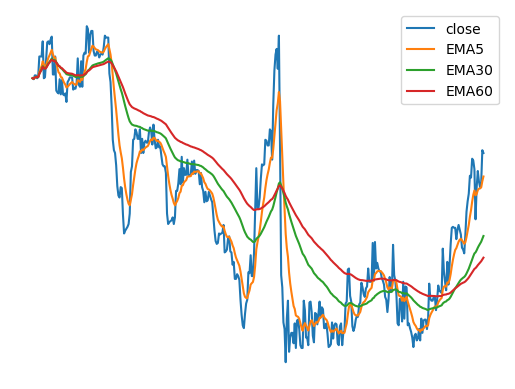

In [5]:
df['EMA5'] = idc.EMA(df,5)
df['EMA30'] = idc.EMA(df,30)
df['EMA60'] = idc.EMA(df,60)

for ema in ['close','EMA5','EMA30','EMA60']:
    plt.plot(df[ema],label=ema)
plt.axis('off')
plt.legend()
plt.show()

### 볼린저밴드
이동평균선을 기준으로 가격이 어느 정도 떨어져 있는지 파악하게 해주는 지표,  
일정 기간의 주가 변동성을 파악한다.

middle을 기준으로 std 만큼 위 아래로 떨어져 있어,  
떨어진 %를 나타내는 BW, BP를 주로 사용한다. 

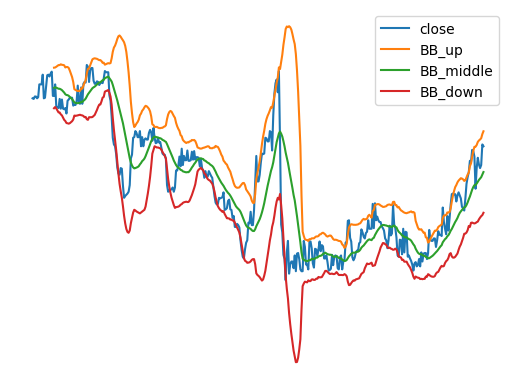

In [6]:
(df['BW'],df['BP']), (df['BB_up'],df['BB_middle'],df['BB_down']) = idc.BB(df,20)

for bp in ['close','BB_up','BB_middle','BB_down']:
    plt.plot(df[bp],label=bp)
plt.axis('off')
plt.legend()
plt.show()

### 모멘텀
단기간 동안에 가격이 변해 온 양을 측정하는 지표,  
시장의 과매도 상태를 나타내는 지표이다. 

양수로 상승할 때는 과매입 상태, 음수로 하락할 경우에는 과매도 상황을 알려준다.  
이는 지지력을 뜻하기도 하여, 추세를 나타내기도 한다. 

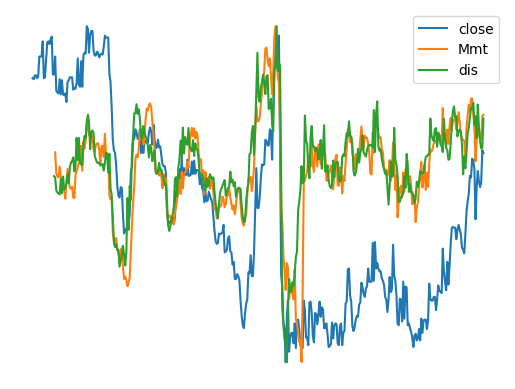

,close,Mmt,dis
count,400.00,380.00,381.00
mean,50671482.50,99.99,100.00
std,100588.72,0.16,0.09
min,50515000.00,99.35,99.60
25%,50581000.00,99.91,99.96
50%,50657500.00,99.99,100.00
75%,50745500.00,100.09,100.05
max,50870000.00,100.46,100.27


In [15]:
df['dis'] = idc.disparity(df, 20)
df['Mmt'] = idc.Mmt(df,20)

for bp in ['close','Mmt','dis']:
    plt.plot(idc.MinMaxN(df[bp]),label=bp)
plt.axis('off')
plt.legend()
plt.show()
df[['close','Mmt','dis']].describe()

### 이동평균 수렴확산 지수 (MACD)
장기 지수이동평균과 단기 지수이동평균 간의 차이

### 상대강도지수 (RSI)
기간 동안 전일에 비해 상승한 변화량과 하락한 변화량의 평균값

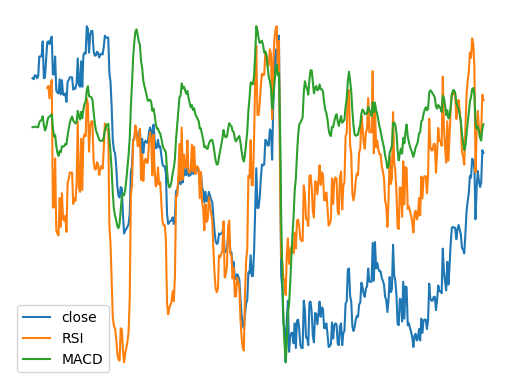

,close,RSI,MACD
count,400.00,387.00,400.00
mean,50671482.50,0.49,221.56
std,100588.72,0.12,6919.75
min,50515000.00,0.16,-36732.66
25%,50581000.00,0.42,-2204.72
50%,50657500.00,0.50,688.66
75%,50745500.00,0.56,3893.95
max,50870000.00,0.77,15776.10


In [16]:
df['RSI'] = idc.RSI(df,14).values / 100
df['MACD'], _ = idc.MACD(df)

for bp in ['close','RSI','MACD']:
    plt.plot(idc.MinMaxN(df[bp]),label=bp)
plt.axis('off')
plt.legend()
plt.show()
df[['close','RSI','MACD']].describe()

## 데이터 병합 및 표준화

In [47]:
df=pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])
df=df.resample(rule='T').first()
df[['volume','value']]=df[['volume','value']].fillna(0)
df=df.interpolate()

df['EMA5'] = idc.EMA(df,5)
df['EMA30'] = idc.EMA(df,30)
df['EMA60'] = idc.EMA(df,60)
(df['BW'],df['BP']), (_,df['BB'],_) = idc.BB(df,20)
df['dis'] = idc.disparity(df, 20)
df['Mmt'] = idc.Mmt(df,20)
df['RSI'] = idc.RSI(df,14).values / 100
df['MACD'], _ = idc.MACD(df)
df.describe()

,open,high,low,close,volume,value,EMA5,EMA30,EMA60,BW,BP,BB,dis,Mmt,RSI,MACD
count,3.249992e+06,3.249992e+06,3.249992e+06,3.249992e+06,3.249992e+06,3.249992e+06,3.249992e+06,3.249992e+06,3.249992e+06,3.249973e+06,3.248944e+06,3.249973e+06,3.249973e+06,3.249972e+06,3.249979e+06,3.249992e+06
mean,2.579619e+07,2.581016e+07,2.578205e+07,2.579606e+07,5.696569e+00,1.471483e+08,2.579599e+07,2.579563e+07,2.579520e+07,5.114233e-03,5.010017e-01,2.579605e+07,1.000011e+02,1.000026e+02,5.014775e-01,2.788927e-02
std,1.955623e+07,1.956690e+07,1.954543e+07,1.955603e+07,1.088398e+01,3.156647e+08,1.955595e+07,1.955565e+07,1.955531e+07,6.012018e-03,3.239695e-01,1.955592e+07,2.455650e-01,4.669149e-01,1.117430e-01,1.054668e+04
min,3.565000e+06,3.568000e+06,3.562000e+06,3.565000e+06,0.000000e+00,0.000000e+00,3.569623e+06,3.577120e+06,3.580441e+06,0.000000e+00,-5.899489e-01,3.572000e+06,8.519793e+01,8.362321e+01,5.655865e-10,-4.675595e+05
25%,9.342000e+06,9.349000e+06,9.334000e+06,9.342000e+06,9.118393e-01,1.356181e+07,9.343040e+06,9.343690e+06,9.344003e+06,2.056627e-03,2.467935e-01,9.343150e+06,9.992738e+01,9.985770e+01,4.329750e-01,-2.011729e+03
50%,1.954500e+07,1.956900e+07,1.952000e+07,1.954500e+07,2.476432e+00,4.766131e+07,1.954439e+07,1.954371e+07,1.954760e+07,3.346963e-03,5.035501e-01,1.954300e+07,1.000011e+02,1.000000e+02,5.011599e-01,-5.471656e+00
75%,3.876000e+07,3.877600e+07,3.874400e+07,3.876000e+07,6.004242e+00,1.493107e+08,3.875955e+07,3.875943e+07,3.875399e+07,5.894268e-03,7.542738e-01,3.875905e+07,1.000755e+02,1.001471e+02,5.693244e-01,1.989043e+03
max,8.269000e+07,8.270000e+07,8.261900e+07,8.269900e+07,7.188566e+02,2.516663e+10,8.244376e+07,8.219372e+07,8.208753e+07,2.959722e-01,1.589725e+00,8.240255e+07,1.197961e+02,1.295759e+02,1.000000e+00,5.284023e+05


#### 표준화

In [48]:
df_c = df['close'].shift()
df['close'] = (df['close'] - df_c) / df_c
df['close'] = df['close'] / df['close'].abs().max()

for i in ['EMA5','EMA30','EMA60']:
    for i in

In [50]:
pd.set_option('display.float_format',None)
df[['close']][2:].describe()

,close
count,3.249990e+06
mean,1.522142e-05
std,1.229857e-02
min,-1.000000e+00
25%,-3.423770e-03
50%,0.000000e+00
75%,3.375113e-03
max,8.570624e-01
